In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
from torch.utils.data import Dataset, DataLoader

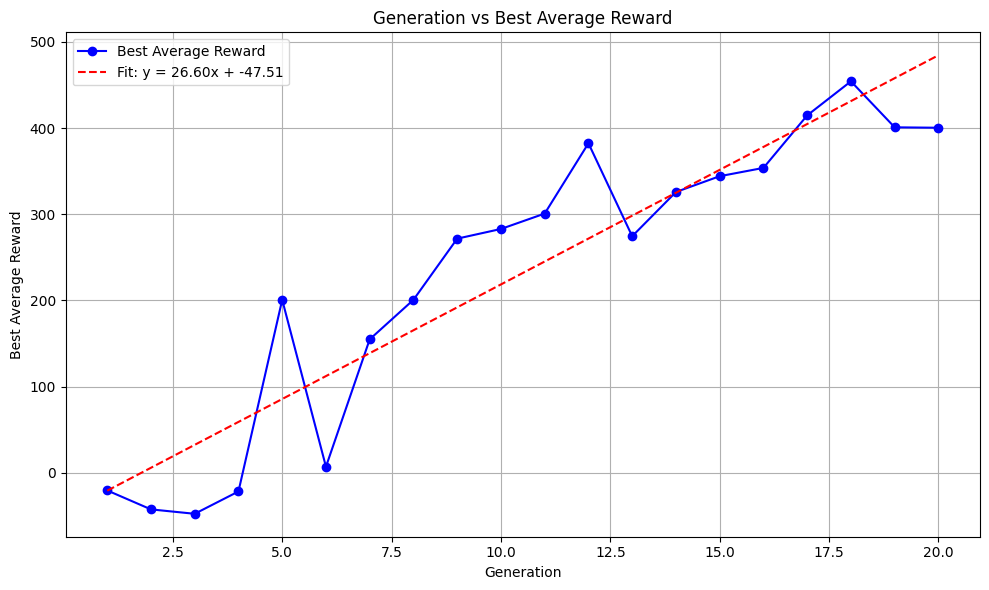

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data arrays
generations = np.arange(1, 21)


### NOT a fake data ####
### THis is calculated below####


rewards = np.array([-20.65, -42.63, -47.75, -21.83, 200.61, 6.88, 154.76, 200.62,
                    271.62, 282.85, 300.73, 382.32, 274.42, 325.75, 344.10, 353.73,
                    414.68, 454.23, 400.83, 400.35])


coeffs = np.polyfit(generations, rewards, 1)
fit_line = np.poly1d(coeffs)

plt.figure(figsize=(10, 6))
plt.plot(generations, rewards, 'bo-', label='Best Average Reward')
plt.plot(generations, fit_line(generations), 'r--',
         label=f'Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')
plt.xlabel('Generation')
plt.ylabel('Best Average Reward')
plt.title('Generation vs Best Average Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> [256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> [1, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample from N(0,1)
        return mu + std * eps          # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [ ]:
import os
import pickle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

class MDN(nn.Module):
    def __init__(self, input_size, output_size, num_mixtures, hidden_units=512):
        super(MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.output_size = output_size
        self.linear = nn.Linear(input_size, 3 * num_mixtures * output_size)
        self.one_div_sqrt_2pi = 1.0 / np.sqrt(2.0 * np.pi)

    def forward(self, x):

        out = self.linear(x)
        split_size = self.num_mixtures * self.output_size
        pi, sigma, mu = torch.split(out, split_size, dim=-1)
        sigma = torch.exp(sigma).view(x.size(0), x.size(1), self.num_mixtures, self.output_size)
        mu    = mu.view(x.size(0), x.size(1), self.num_mixtures, self.output_size)
        pi    = F.softmax(pi.view(x.size(0), x.size(1), self.num_mixtures, self.output_size), dim=2)
        return pi, sigma, mu

    def gaussian_distribution(self, y, mu, sigma):
        y = y.unsqueeze(2).expand_as(sigma)
        exponent = -0.5 * ((y - mu) / sigma) ** 2
        return (torch.exp(exponent) / sigma) * self.one_div_sqrt_2pi

    def loss_fn(self, y, pi, mu, sigma):
        prob = self.gaussian_distribution(y, mu, sigma)
        prob = prob * pi
        prob = torch.sum(prob, dim=2)  # sum over mixtures → [batch, seq, output_size]
        prob = torch.clamp(prob, min=1e-24)
        loss = -torch.log(prob)
        return torch.mean(loss)

class MDNRNN(nn.Module):
    def __init__(self, input_size, output_size, num_mixtures=5, hidden_size=256):
        super(MDNRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.mdn = MDN(hidden_size, output_size, num_mixtures)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        pi, sigma, mu = self.mdn(lstm_out)
        return pi, sigma, mu, hidden

    def loss_fn(self, y, pi, mu, sigma):
        return self.mdn.loss_fn(y, pi, mu, sigma)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MDNRNN(input_size=35, output_size=32, num_mixtures=5, hidden_size=256).to(device)
# save_path="/content/drive/MyDrive/mdn_rnn_with_vae.pth"
# torch.save(model.state_dict(), save_path)
!pip install cma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379450 sha256=ff1dbbfe843559431db60b3e4f5ce1e5a98786c77723d246fc3d39f0badff280
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import cv2
import numpy as np
import torch
import torch.nn as nn
import cma


latent_dim = 32
mdnrnn_hidden_size = 256
action_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vae = VAE(latent_dim).to(device)
vae_weights_path = "/content/drive/MyDrive/vae_car_racing.pth"
vae.load_state_dict(torch.load(vae_weights_path, map_location=device, weights_only=True))
vae.eval()


mdnrnn = MDNRNN(input_size=latent_dim + action_dim, output_size=latent_dim, num_mixtures=5, hidden_size=mdnrnn_hidden_size).to(device)
mdnrnn_weights_path = "/content/drive/MyDrive/mdn_rnn_with_vae.pth"
mdnrnn.load_state_dict(torch.load(mdnrnn_weights_path, map_location=device))
mdnrnn.eval()


# Input: MDN-RNN hidden state (256), VAE encoding (32)..... total 288.
input_dim = mdnrnn_hidden_size + latent_dim  # 256 + 32 = 288

class Controller(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(Controller, self).__init__()
        self.linear = nn.Linear(input_dim, action_dim)
    def forward(self, x):
        return torch.tanh(self.linear(x))

def get_param_dim(input_dim, action_dim):
    return input_dim * action_dim + action_dim

def set_controller_params(controller, flat_params):
    weight_shape = controller.linear.weight.shape  # (action_dim, input_dim)
    bias_shape = controller.linear.bias.shape        # (action_dim,)
    num_weight = np.prod(weight_shape)
    weight = flat_params[:num_weight].reshape(weight_shape)
    bias = flat_params[num_weight:num_weight + np.prod(bias_shape)]
    with torch.no_grad():
        controller.linear.weight.copy_(torch.tensor(weight, dtype=torch.float32))
        controller.linear.bias.copy_(torch.tensor(bias, dtype=torch.float32))

param_dim = get_param_dim(input_dim, action_dim)
controller = Controller(input_dim, action_dim).to(device)

def evaluate_controller(flat_params, controller, episodes=3, render=False):
    set_controller_params(controller, flat_params)
    total_reward = 0
    for ep in range(episodes):
        env = gym.make('CarRacing-v3', render_mode='rgb_array')
        obs, _ = env.reset()
        h = torch.zeros(1, 1, mdnrnn_hidden_size, device=device)
        c = torch.zeros(1, 1, mdnrnn_hidden_size, device=device)
        mdnrnn_hidden = (h, c)
        done = False
        ep_reward = 0
        while not done:

            obs_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
            obs_resized = cv2.resize(obs_gray, (64, 64))
            obs_tensor = torch.tensor(obs_resized, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0) / 255.0
            with torch.no_grad():
                mu, _ = vae.encode(obs_tensor)
            z = mu.squeeze(0)
            h_current = mdnrnn_hidden[0].squeeze(0).squeeze(0)
            controller_input = torch.cat([h_current, z], dim=0)
            with torch.no_grad():
                action = controller(controller_input.unsqueeze(0)).squeeze(0)
            action_np = action.cpu().numpy()

            obs, reward, done, truncated, _ = env.step(action_np)
            ep_reward += reward

            mdn_input = torch.cat([z, action], dim=0).unsqueeze(0).unsqueeze(0)
            with torch.no_grad():
                _, mdnrnn_hidden = mdnrnn.lstm(mdn_input, mdnrnn_hidden)

            if render:
                env.render()
            done = done or truncated
        env.close()
        total_reward += ep_reward
    return total_reward / episodes

#CMAES
def objective(flat_params):
    avg_reward = evaluate_controller(flat_params, controller, episodes=3)
    return -avg_reward


es = cma.CMAEvolutionStrategy(np.zeros(param_dim), 0.5, {'popsize': 20, 'maxiter': 300})

generation = 0
while not es.stop():
    generation += 1
    solutions = es.ask()
    fitnesses = [objective(s) for s in solutions]


    best_idx = np.argmin(fitnesses)
    best_gen_reward = -fitnesses[best_idx]
    print(f"Generation {generation}: Best Average Reward = {best_gen_reward:.2f}")


    if generation % 5 == 0:

        save_path = f"/content/drive/MyDrive/controller_params_gen_{generation}.npy"
        np.save(save_path, solutions[best_idx])
        print(f"Saved best controller parameters for generation {generation} at {save_path}")

    es.tell(solutions, fitnesses)
    es.disp()  # This prints internal CMA-ES stats

best_params = es.result.xbest
np.save("/content/drive/MyDrive/controller_params_final.npy", best_params)
print("Controller training complete. Model saved.")


<ipython-input-9-ec09fdb1b6ce>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mdnrnn.load_state_dict(torch.load(mdnrnn_weights_path, map_location=device))


(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 867 (seed=209176, Tue Mar  4 17:26:13 2025)
Generation 1: Best Average Reward = 92.51
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 -9.251142722884661e+01 1.0e+00 4.96e-01  5e-01  5e-01 18:50.3
Generation 2: Best Average Reward = -20.99
    2     40 2.098781721423272e+01 1.0e+00 4.92e-01  5e-01  5e-01 37:15.0
Generation 3: Best Average Reward = 109.71
    3     60 -1.097088955528885e+02 1.0e+00 4.89e-01  5e-01  5e-01 55:50.2
Generation 4: Best Average Reward = 63.32
    4     80 -6.332367778273160e+01 1.0e+00 4.86e-01  5e-01  5e-01 74:42.7
Generation 5: Best Average Reward = 76.99
Saved best controller parameters for generation 5 at /content/drive/MyDrive/controller_params_gen_5.npy
    5    100 -7.698774393609621e+01 1.0e+00 4.83e-01  5e-01  5e-01 92:45.0
Generation 6: Best Average Reward = 274.51
    6    120 -2.745120399826364e+02 1.0e+00 4.80e-01  5e-01  5e-01 111:02.8
Generation 7: Best Averag

In [ ]:
best_params = es.result.xbest
np.save("/content/drive/MyDrive/controller_params_final.npy", best_params)
print("Controller training complete. Model saved.")